<a href="https://colab.research.google.com/github/rohts-patil/VQA-Med-2019/blob/master/notebooks/VQA_Organ_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/VQA

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/VQA


In [0]:
import glob
import random

import numpy as np
import pandas as pd

import time
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import LabelEncoder
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
from torch import optim, cuda
from timeit import default_timer as timer

In [0]:
path =r'train/QAPairsByCategory'

filenames = glob.glob(path + "/*.txt")

dfs = []

for filename in filenames:
    df_temp = pd.read_csv(filename,delimiter='|',names=['id','question','answer'])
    df_temp['label'] = df_temp.apply(lambda x: ((filename.split('/')[-1].replace('_train.txt',''))), axis=1)
    dfs.append(df_temp)

df_train = pd.concat(dfs, ignore_index=True)

In [4]:
df_train.head()

,id,question,answer,label
0,synpic41148,what kind of image is this?,cta - ct angiography,C1_Modality
1,synpic43984,is this a t1 weighted image?,no,C1_Modality
2,synpic38930,what type of imaging modality is used to acqui...,us - ultrasound,C1_Modality
3,synpic52143,is this a noncontrast mri?,no,C1_Modality
4,synpic20934,what type of image modality is this?,xr - plain film,C1_Modality


In [0]:
path =r'val/QAPairsByCategory'

filenames = glob.glob(path + "/*.txt")

dfs = []

for filename in filenames:
    df_temp = pd.read_csv(filename,delimiter='|',names=['id','question','answer'])
    df_temp['label'] = df_temp.apply(lambda x: (filename.split('/')[-1].replace('_val.txt','')), axis=1)
    dfs.append(df_temp)

df_valid = pd.concat(dfs, ignore_index=True)

In [6]:
df_valid.head()

,id,question,answer,label
0,synpic54733,what imaging modality was used to take this im...,ct with iv contrast,C1_Modality
1,synpic25647,what kind of scan is this?,xr - plain film,C1_Modality
2,synpic35681,was the mri taken with contrast?,no,C1_Modality
3,synpic39641,"is this a t1 weighted, t2 weighted, or flair i...",t2,C1_Modality
4,synpic35693,is this a noncontrast mri?,yes,C1_Modality


In [7]:
df_train = df_train[df_train['label'] == 'C3_Organ']
df_train.head()

,id,question,answer,label
6400,synpic41148,which organ is captured by this ct scan?,"lung, mediastinum, pleura",C3_Organ
6401,synpic43984,what organ system is primarily present in this...,skull and contents,C3_Organ
6402,synpic38930,which organ system is imaged?,genitourinary,C3_Organ
6403,synpic52143,the mri shows what organ system?,spine and contents,C3_Organ
6404,synpic20934,what organ system is shown in this x-ray?,spine and contents,C3_Organ


In [8]:
df_valid = df_valid[df_valid['label'] == 'C3_Organ']
df_valid.head()

,id,question,answer,label
1000,synpic54733,what organ system is shown in the image?,"face, sinuses, and neck",C3_Organ
1001,synpic25647,what organ system is being imaged?,"lung, mediastinum, pleura",C3_Organ
1002,synpic35681,what part of the body is being imaged?,breast,C3_Organ
1003,synpic39641,what organ system is pictured here?,musculoskeletal,C3_Organ
1004,synpic35693,what is the organ principally shown in this mri?,heart and great vessels,C3_Organ


In [9]:
labelencoder = LabelEncoder()
df_train['organ_type'] = labelencoder.fit_transform(df_train['answer'])
df_train.head()

,id,question,answer,label,organ_type
6400,synpic41148,which organ is captured by this ct scan?,"lung, mediastinum, pleura",C3_Organ,5
6401,synpic43984,what organ system is primarily present in this...,skull and contents,C3_Organ,7
6402,synpic38930,which organ system is imaged?,genitourinary,C3_Organ,3
6403,synpic52143,the mri shows what organ system?,spine and contents,C3_Organ,8
6404,synpic20934,what organ system is shown in this x-ray?,spine and contents,C3_Organ,8


In [10]:
df_valid['organ_type'] = labelencoder.fit_transform(df_valid['answer'])
df_valid.head()

,id,question,answer,label,organ_type
1000,synpic54733,what organ system is shown in the image?,"face, sinuses, and neck",C3_Organ,1
1001,synpic25647,what organ system is being imaged?,"lung, mediastinum, pleura",C3_Organ,5
1002,synpic35681,what part of the body is being imaged?,breast,C3_Organ,0
1003,synpic39641,what organ system is pictured here?,musculoskeletal,C3_Organ,6
1004,synpic35693,what is the organ principally shown in this mri?,heart and great vessels,C3_Organ,4


In [11]:
integer_mapping = {l: i for i, l in enumerate(labelencoder.classes_)}
integer_mapping

{'breast': 0,
 'face, sinuses, and neck': 1,
 'gastrointestinal': 2,
 'genitourinary': 3,
 'heart and great vessels': 4,
 'lung, mediastinum, pleura': 5,
 'musculoskeletal': 6,
 'skull and contents': 7,
 'spine and contents': 8,
 'vascular and lymphatic': 9}

In [0]:
class OrganDataSet(Dataset):
    def __init__(self, image_names,organ_types, root_dir, transform=None):
        self.image_names = image_names
        self.organ_types = organ_types
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = '{}.jpg'.format(self.image_names[idx])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.organ_types[idx]
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [0]:
organ_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
train_ds = OrganDataSet(df_train['id'].values,df_train['organ_type'].values, r'train/Train_images/', transform=organ_trans)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)

organ_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
train_ds = OrganDataSet(df_train['id'].values,df_train['organ_type'].values, r'train/Train_images/', transform=organ_trans)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)

valid_ds = OrganDataSet(df_valid['id'].values,df_valid['organ_type'].values, r'val/Val_images/', transform=organ_trans)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, num_workers=4)

In [0]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

In [0]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224]) torch.Size([32])


IndexError: ignored

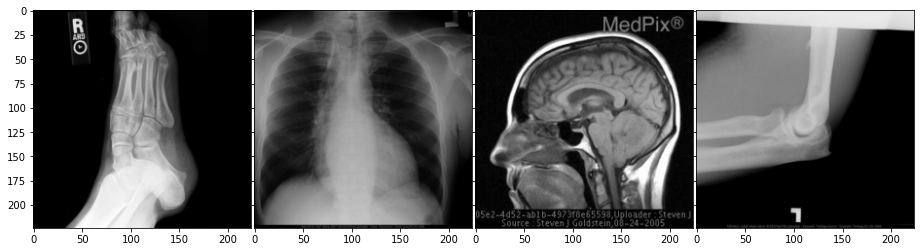

In [26]:
img, label = next(iter(valid_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

In [0]:
train_on_gpu = cuda.is_available()
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = torch.nn.Sequential(
            torch.nn.Linear(n_inputs, 256), torch.nn.ReLU(), torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 10), torch.nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = torch.nn.Sequential(
            torch.nn.Linear(n_inputs, 256), torch.nn.ReLU(), torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 10), torch.nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    return model

In [18]:
model = get_pretrained_model('vgg16')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
criterion = torch.nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [0]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [27]:
  model, history = train(
    model,
    criterion,
    optimizer,
    train_dl,
    valid_dl,
    save_file_name="vgg",
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Model has been trained for: 0 epochs.


Epoch: 1 	Training Loss: 1.0991 	Validation Loss: 1.0230
		Training Accuracy: 64.84%	 Validation Accuracy: 67.00%

Epoch: 3 	Training Loss: 0.9585 	Validation Loss: 0.9662
		Training Accuracy: 69.06%	 Validation Accuracy: 70.40%

Epoch: 5 	Training Loss: 0.8416 	Validation Loss: 0.9565
		Training Accuracy: 72.22%	 Validation Accuracy: 71.40%

Epoch: 7 	Training Loss: 0.7630 	Validation Loss: 0.9462
		Training Accuracy: 75.31%	 Validation Accuracy: 71.60%

Epoch: 9 	Training Loss: 0.6905 	Validation Loss: 0.9384
		Training Accuracy: 77.41%	 Validation Accuracy: 72.60%

Epoch: 11 	Training Loss: 0.6294 	Validation Loss: 0.9278
		Training Accuracy: 78.69%	 Validation Accuracy: 72.20%

Epoch: 13 	Training Loss: 0.5697 	Validation Loss: 0.9504
		Training Accuracy: 80.62%	 Validation Accuracy: 73.00%

Epoch: 15 	Training Loss: 0.5324 	Validation Loss: 0.9422
		Training Accuracy: 82.09%	 Validation Accuracy: 75.40%

Early Stopping! Total epochs: 16. Bes

Text(0.5, 1.0, 'Training and Validation Losses')

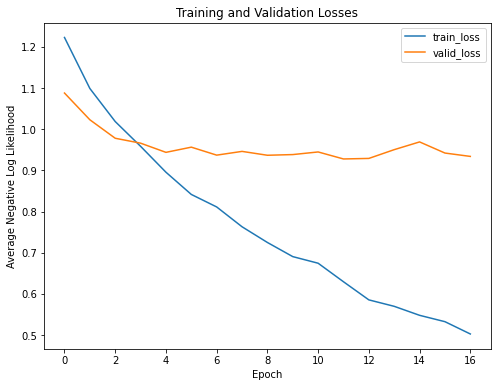

In [28]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

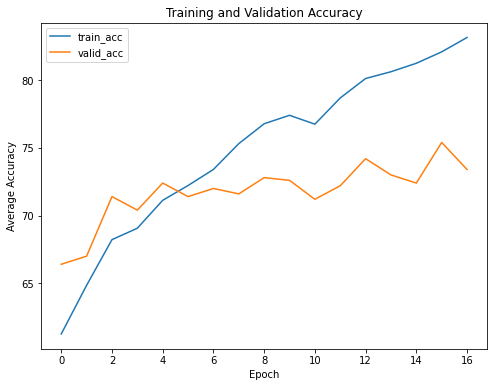

In [29]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [0]:
multi_gpu = False
def save_checkpoint(model, path,model_name):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [0]:
torch.save(model.state_dict(), 'organ-vgg16.pt')
#save_checkpoint(model, path='organ/vgg16.pth',model_name='vgg16')